In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import objective_functions as obj_fun

In [62]:
df1 = pd.read_csv("../results/michalewicz_function/michalewicz_function_02_Jan_2022_01_17_13.csv")
df1.hyperspace.unique()

array([27, 30,  5, 16,  2,  7, 24, 19, 11, 15, 26, 29, 17, 23,  3, 25, 31,
       20, 10, 21,  4])

# Bird function

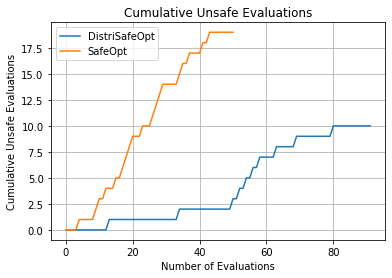

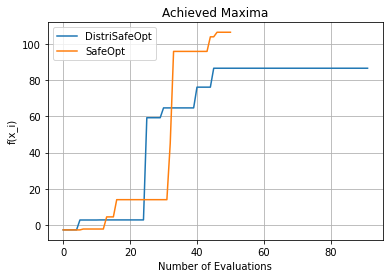

In [46]:
df1 = pd.read_csv("../results/bird_function/bird_function_02_Jan_2022_01_14_34.csv")
df2 = pd.read_csv("../results/bird_function/bird_function_sbo_02_Jan_2022_00_57_28.csv")

# cumulative unsafe evaluations
unsafe1 = []
for unsafety in df1.y < obj_fun.BIRD_FUNCTION_THRESHOLD:
    if unsafety:
        unsafe1.append(1)
    else:
        unsafe1.append(0)

unsafe1 = np.array(unsafe1)
plt.xlabel("Number of Evaluations")
plt.ylabel("Cumulative Unsafe Evaluations")
plt.title("Cumulative Unsafe Evaluations")
plt.grid(True)
plt.plot(np.cumsum(unsafe1))

unsafe2 = []
for unsafety in df2.y < obj_fun.BIRD_FUNCTION_THRESHOLD:
    if unsafety:
        unsafe2.append(1)
    else:
        unsafe2.append(0)
unsafe2 = np.array(unsafe2)
plt.plot(np.cumsum(unsafe2))
plt.legend(["DistriSafeOpt", "SafeOpt"], loc="upper left")
plt.savefig("bird-cum-unsafe.pdf", format="pdf")
plt.show()


# achieved maxima
maxima1 = []
maximum = df1.y[0]
for y in df1.y:
    if y > maximum:
        maximum = y
    maxima1.append(maximum)
maxima1 = np.array(maxima1)
plt.xlabel("Number of Evaluations")
plt.ylabel("f(x_i)")
plt.title("Achieved Maxima")
plt.grid(True)
plt.plot(maxima1)

maxima2 = []
maximum = df2.y[0]
for y in df2.y:
    if y > maximum:
        maximum = y
    maxima2.append(maximum)
maxima2 = np.array(maxima2)
plt.plot(maxima2)
plt.legend(["DistriSafeOpt", "SafeOpt"], loc="upper left")
plt.savefig("bird-maxima.pdf", format="pdf")
plt.show()

# Langermann function

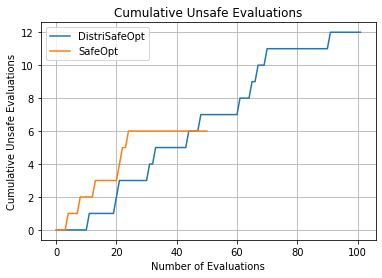

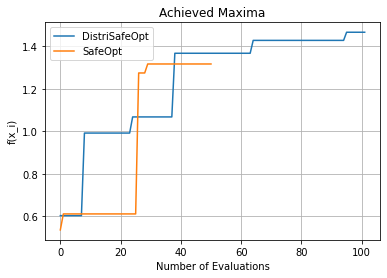

In [47]:
df1 = pd.read_csv("../results/langermann_function/langermann_function_02_Jan_2022_01_31_35.csv")
df2 = pd.read_csv("../results/langermann_function/langermann_function_sbo_02_Jan_2022_10_03_53.csv")

# cumulative unsafe evaluations
unsafe1 = []
for unsafety in df1.y < obj_fun.LANGERMANN_FUNCTION_THRESHOLD:
    if unsafety:
        unsafe1.append(1)
    else:
        unsafe1.append(0)

unsafe1 = np.array(unsafe1)
plt.xlabel("Number of Evaluations")
plt.ylabel("Cumulative Unsafe Evaluations")
plt.title("Cumulative Unsafe Evaluations")
plt.grid(True)
plt.plot(np.cumsum(unsafe1))

unsafe2 = []
for unsafety in df2.y < obj_fun.LANGERMANN_FUNCTION_THRESHOLD:
    if unsafety:
        unsafe2.append(1)
    else:
        unsafe2.append(0)
unsafe2 = np.array(unsafe2)
plt.plot(np.cumsum(unsafe2))
plt.legend(["DistriSafeOpt", "SafeOpt"], loc="upper left")
plt.savefig("langermann-cum-unsafe.pdf", format="pdf")
plt.show()


# achieved maxima
maxima1 = []
maximum = df1.y[0]
for y in df1.y:
    if y > maximum:
        maximum = y
    maxima1.append(maximum)
maxima1 = np.array(maxima1)
plt.xlabel("Number of Evaluations")
plt.ylabel("f(x_i)")
plt.title("Achieved Maxima")
plt.grid(True)
plt.plot(maxima1)

maxima2 = []
maximum = df2.y[0]
for y in df2.y:
    if y > maximum:
        maximum = y
    maxima2.append(maximum)
maxima2 = np.array(maxima2)
plt.plot(maxima2)
plt.legend(["DistriSafeOpt", "SafeOpt"], loc="upper left")
plt.savefig("langermann-maxima.pdf", format="pdf")
plt.show()

# Levy05 function

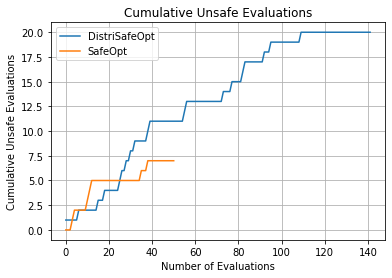

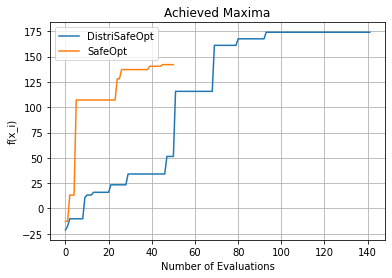

In [48]:
df1 = pd.read_csv("../results/levy05_function/levy05_function_02_Jan_2022_01_25_29.csv")
df2 = pd.read_csv("../results/levy05_function/levy05_function_sbo_02_Jan_2022_10_30_27.csv")

# cumulative unsafe evaluations
unsafe1 = []
for unsafety in df1.y < obj_fun.LEVY05_FUNCTION_THRESHOLD:
    if unsafety:
        unsafe1.append(1)
    else:
        unsafe1.append(0)

unsafe1 = np.array(unsafe1)
plt.xlabel("Number of Evaluations")
plt.ylabel("Cumulative Unsafe Evaluations")
plt.title("Cumulative Unsafe Evaluations")
plt.grid(True)
plt.plot(np.cumsum(unsafe1))

unsafe2 = []
for unsafety in df2.y < obj_fun.LEVY05_FUNCTION_THRESHOLD:
    if unsafety:
        unsafe2.append(1)
    else:
        unsafe2.append(0)
unsafe2 = np.array(unsafe2)
plt.plot(np.cumsum(unsafe2))
plt.legend(["DistriSafeOpt", "SafeOpt"], loc="upper left")
plt.savefig("levy05-cum-unsafe.pdf", format="pdf")
plt.show()


# achieved maxima
maxima1 = []
maximum = df1.y[0]
for y in df1.y:
    if y > maximum:
        maximum = y
    maxima1.append(maximum)
maxima1 = np.array(maxima1)
plt.xlabel("Number of Evaluations")
plt.ylabel("f(x_i)")
plt.title("Achieved Maxima")
plt.grid(True)
plt.plot(maxima1)

maxima2 = []
maximum = df2.y[0]
for y in df2.y:
    if y > maximum:
        maximum = y
    maxima2.append(maximum)
maxima2 = np.array(maxima2)
plt.plot(maxima2)
plt.legend(["DistriSafeOpt", "SafeOpt"], loc="upper left")
plt.savefig("levy05-maxima.pdf", format="pdf")
plt.show()

# Michalewicz function

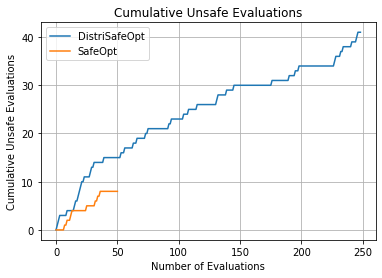

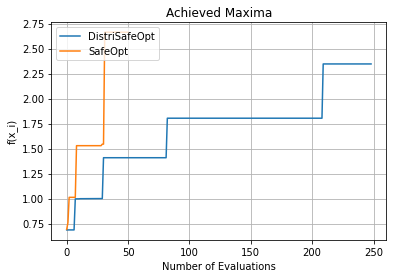

In [50]:
df1 = pd.read_csv("../results/michalewicz_function/michalewicz_function_02_Jan_2022_01_17_13.csv")
df2 = pd.read_csv("../results/michalewicz_function/michalewicz_function_sbo_02_Jan_2022_00_55_00.csv")

# cumulative unsafe evaluations
unsafe1 = []
for unsafety in df1.y < obj_fun.MICHALEWICZ_FUNCTION_THRESHOLD:
    if unsafety:
        unsafe1.append(1)
    else:
        unsafe1.append(0)

unsafe1 = np.array(unsafe1)
plt.xlabel("Number of Evaluations")
plt.ylabel("Cumulative Unsafe Evaluations")
plt.title("Cumulative Unsafe Evaluations")
plt.grid(True)
plt.plot(np.cumsum(unsafe1))

unsafe2 = []
for unsafety in df2.y < 0.1:
    if unsafety:
        unsafe2.append(1)
    else:
        unsafe2.append(0)
unsafe2 = np.array(unsafe2)
plt.plot(np.cumsum(unsafe2))
plt.legend(["DistriSafeOpt", "SafeOpt"], loc="upper left")
plt.savefig("michalewicz-cum-unsafe.pdf", format="pdf")
plt.show()


# achieved maxima
maxima1 = []
maximum = df1.y[0]
for y in df1.y:
    if y > maximum:
        maximum = y
    maxima1.append(maximum)
maxima1 = np.array(maxima1)
plt.xlabel("Number of Evaluations")
plt.ylabel("f(x_i)")
plt.title("Achieved Maxima")
plt.grid(True)
plt.plot(maxima1)

maxima2 = []
maximum = df2.y[0]
for y in df2.y:
    if y > maximum:
        maximum = y
    maxima2.append(maximum)
maxima2 = np.array(maxima2)
plt.plot(maxima2)
plt.legend(["DistriSafeOpt", "SafeOpt"], loc="upper left")
plt.savefig("michalewicz-maxima.pdf", format="pdf")
plt.show()